## Analysis ##

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

url = 'http://apmonitor.com/pds/uploads/Main/wind.txt'
data = pd.read_csv(url)
data.columns = ['Time', 'Direction', 'Speed', 'Power']
#data['lnPower'] = np.log(data['Power'].values) # just in case...? idk, Dr. H did this way back when just for funsies?
data.describe()

,Direction,Speed,Power
count,50530.000000,50530.000000,50530.000000
mean,123.687559,7.557952,1307.684332
std,93.443736,4.227166,1312.459242
min,0.000000,0.000000,-2.471405
25%,49.315437,4.201395,50.677890
50%,73.712978,7.104594,825.838074
75%,201.696720,10.300020,2482.507568
max,359.997589,25.206011,3618.732910


In [2]:
profile = ProfileReport(data, explorative = True, minimal = False)

In [3]:
# profile.to_widgets() might be a tad 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Visualization ##

In [4]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

data_time = data['Time'].copy() # for LSTM later on
data = data.dropna()


In [5]:
data.head()

,Time,Direction,Speed,Power
0,2018-01-01 00:00,259.994904,5.311336,380.047791
1,2018-01-01 00:10,268.641113,5.672167,453.769196
2,2018-01-01 00:20,272.564789,5.216037,306.376587
3,2018-01-01 00:30,271.258087,5.659674,419.645904
4,2018-01-01 00:40,265.674286,5.577941,380.650696


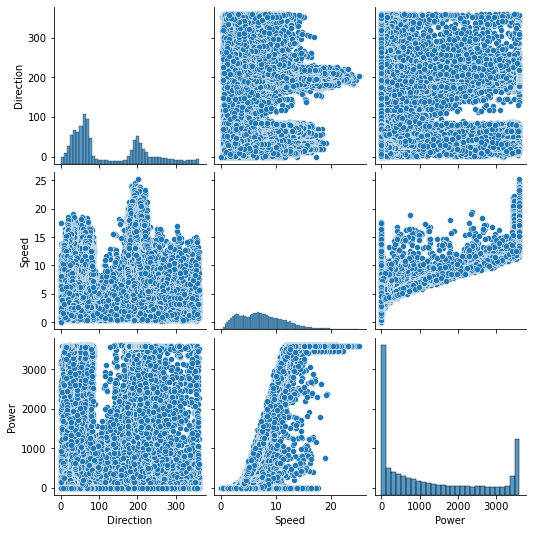

In [6]:
sns.pairplot(data)
plt.show()

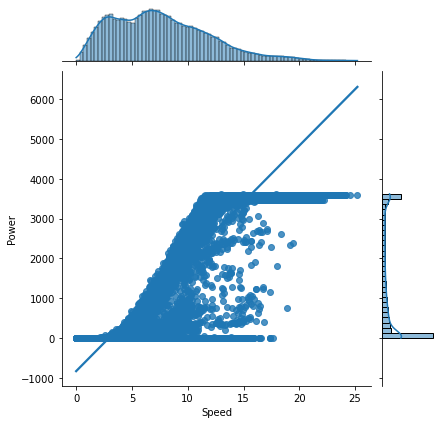

In [7]:
sns.jointplot(x = 'Speed', y = 'Power', data = data, kind = 'reg')
plt.show()

In [8]:
'''So according to the wind power curve modeling thing that Dr. Hedengren gave us, we should be able to cleanse this into
a curve of some kind. There shouldn't be any bottom leveling from this by the time we are done. This can be found at the link
given here: https://www.kaggle.com/winternguyen/wind-power-curve-modeling'''

"So according to the wind power curve modeling thing that Dr. Hedengren gave us, we should be able to cleanse this into\na curve of some kind. There shouldn't be any bottom leveling from this by the time we are done. This can be found at the link\ngiven here: https://www.kaggle.com/winternguyen/wind-power-curve-modeling"

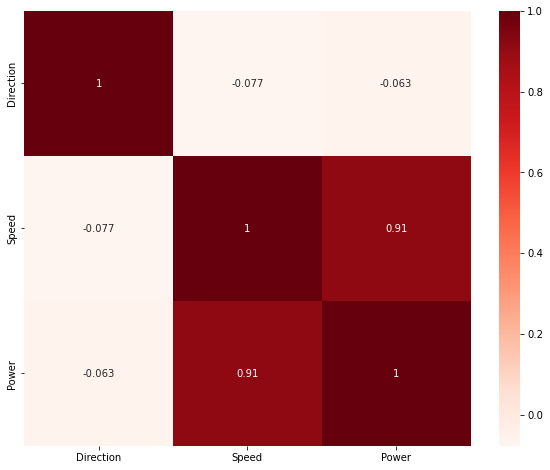

In [9]:
plt.figure(figsize = (10, 8))
correlation = data.corr()
sns.heatmap(correlation, annot = True, cmap = plt.cm.Reds)
plt.show()

## Data Preparation ##

In [ ]:
# So speed is the most important, followed by direction 

In [10]:
# Totally unnecessary, but part of me wanted to check to make sure I had 
# everything set. This came from that link Dr. Hedengren provided on the
# problem statement.

from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

In [11]:
def outlier_remover(dat, prop, min, max):
    d = dat
    q_low = d[prop].quantile(min)
    q_hi  = d[prop].quantile(max)
    return d[(d[prop] < q_hi) & (d[prop] > q_low)]

# Create Sub-DataFrames
d = {}
step = 50
i = 1
for x in range(20, 3400, step):
    d[i] = data.iloc[((data['Power']>=x)&((data['Power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

d[69] = data.iloc[(data['Power']>=3300).values]

# Remove outlier
for x in range(1, 70):
    if x <= 3:
        F = 0.95
    elif ((x > 3) and (x <= 10)):
        F = 0.9
    elif ((x > 10) and (x <= 20)):
        F = 0.92
    elif ((x > 20) and (x < 30)):
        F = 0.96
    else:
        F = 0.985
    d[x] = outlier_remover(d[x], 'Speed', 0.0001, F)
    
df=pd.DataFrame()
for infile in range(1,70):
    data = d[infile]
    df=df.append(data,ignore_index=True)

There are in total of 68 DataFrames


In [12]:
df.shape

(37803, 4)

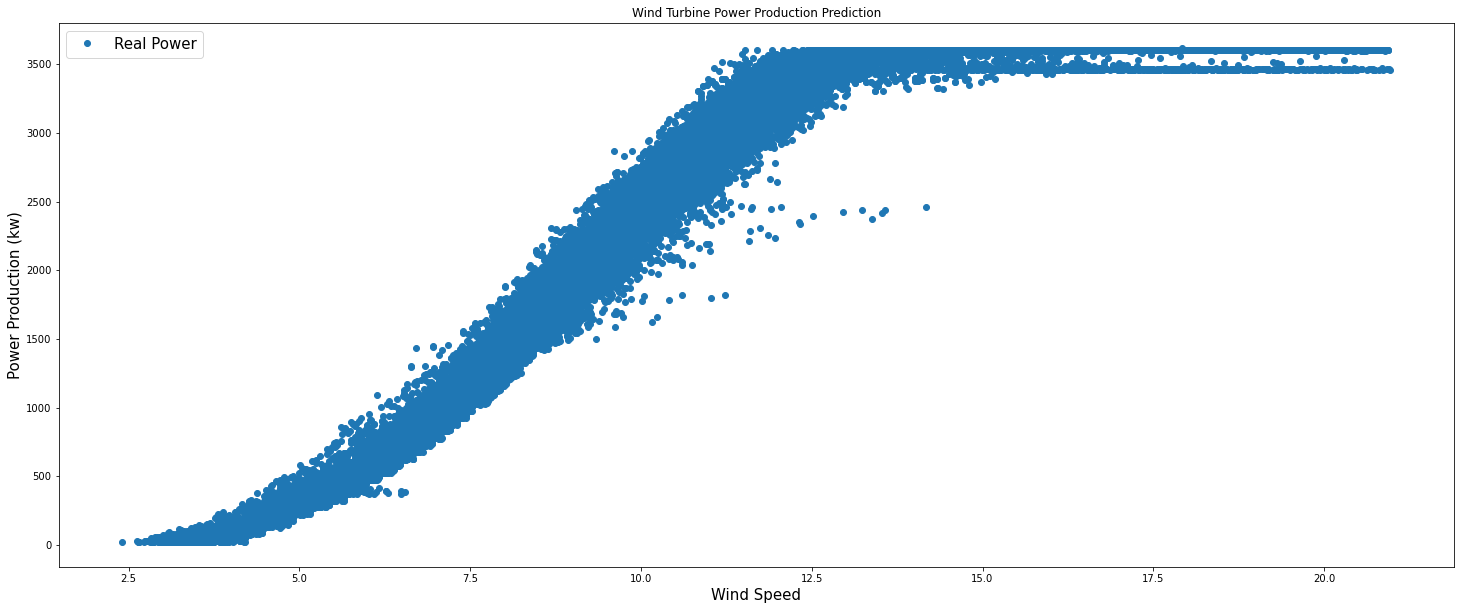

In [13]:
# Cleaner data

data = df
data_time = data['Time'].copy() # for LSTM
del data['Time']

exp = data['Power']
#the = data['Theoretical_Power_Curve (KWh)']
plt.figure(figsize=(25,10)) 
plt.plot(data['Speed'], data['Power'], 'o', label='Real Power')
#plt.plot(data['Speed'], data['Theoretical_Power_Curve (KWh)'], '.', label='theoretical_power_curve (kwh)')
plt.xlabel('Wind Speed', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()

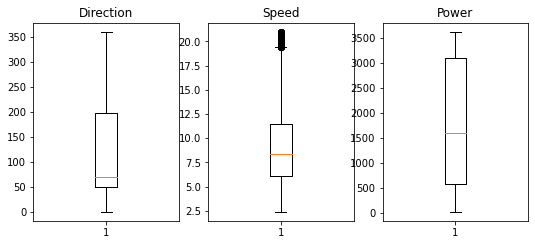

In [14]:
plt.figure(figsize = (12, 8))

for i, c in enumerate(data.columns):
    if i <= 4:
        plt.subplot(2, 4, i + 1)
        plt.title(c)
        plt.boxplot(data[c])
plt.show()

## Regression ##

In [15]:
ftrain = ['Speed', 'Direction', 'Power']

hls = (3,)
a = 'tanh'
s = 'lbfgs'
mi = 5000

def Definedata():
    # define dataset
    data2 = df[ftrain]
    X = data2.drop(columns=['Power']).values
    y = data2['Power'].values
    #lab_enc = preprocessing.LabelEncoder()
    #y = lab_enc.fit_transform(y0)
    return X, y

def Models(models):
    
    model = models
    
    if model == MLPRegressor(hidden_layer_sizes = hls, activation = a, solver = s, max_iter = mi):
        X, y = Definedata()
        X = X.reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 25)
        y_pred = model.predict(X_test)
        y_total = model.predict(X)
        
    else:
        X, y = Definedata()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 25)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        y_total = model.predict(X)
    
    print("\t\tError Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Accuracy on Training set : ', model.score(X_train,y_train))
    print('Accuracy on Testing set  : ', model.score(X_test,y_test))
    return y_total, y

def Featureimportances(models):
    model = models
    model.fit(X_train,y_train)
    importances = model.feature_importances_
    features = df_test.columns[:9]
    imp = pd.DataFrame({'Features': ftest, 'Importance': importances})
    imp['Sum Importance'] = imp['Importance'].cumsum()
    imp = imp.sort_values(by = 'Importance')
    return imp

def Graph_prediction(y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    #TP = df['Theoretical_Power_Curve (KWh)']
    number = len(df['Speed'])
    aa=[x for x in df['Speed']]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number], 'o', label='Real Power')
    plt.plot(aa, y_total[:number], 'x', label='Predicted Power')
    #plt.plot(aa, TP[:number], '.', label='theoretical_power_curve (kwh)')
    
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()

## Approach 1 ##
### XGBoost ###

		Error Table
Mean Absolute Error      :  75.2802871867107
Mean Squared  Error      :  12898.046433423628
Root Mean Squared  Error :  113.56956649306903
Accuracy on Training set :  0.9947960597986527
Accuracy on Testing set  :  0.9918707715695912


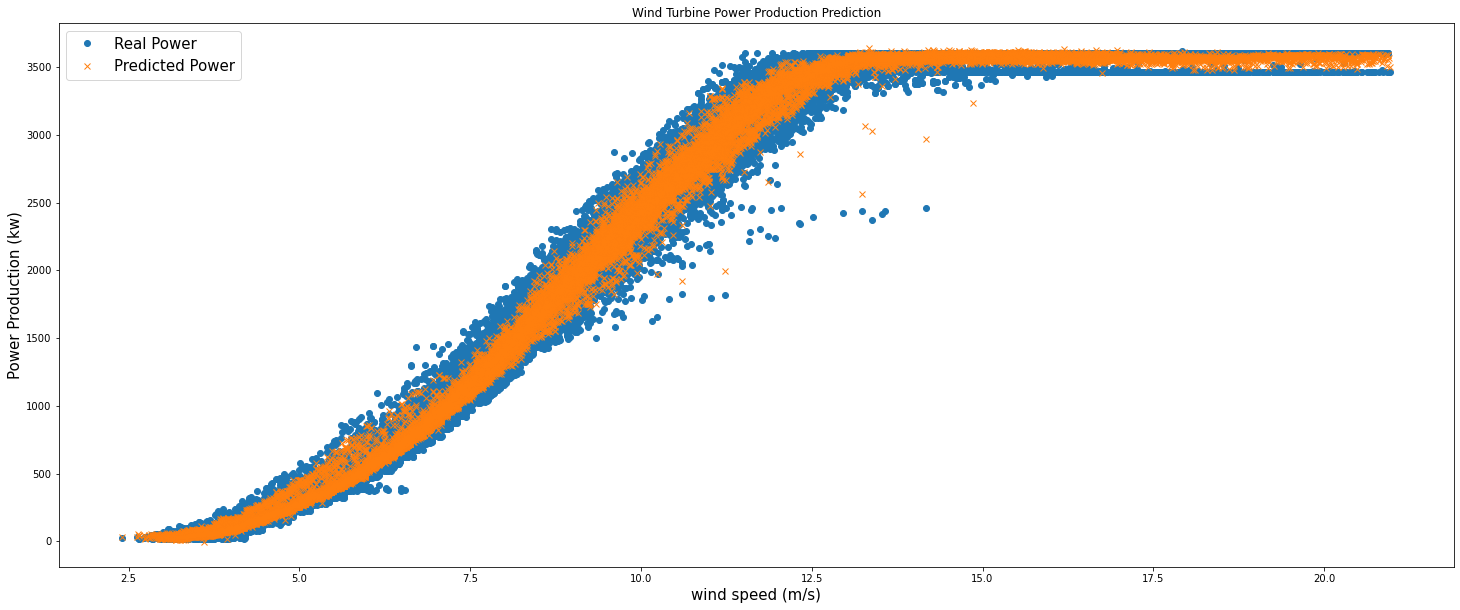

In [16]:
y_predicted, y_actual = Models(XGBRegressor())
Graph_prediction(y_actual, y_predicted)

### Neural Network ###

		Error Table
Mean Absolute Error      :  92.88069110914586
Mean Squared  Error      :  16878.44071600049
Root Mean Squared  Error :  129.91705321473577
Accuracy on Training set :  0.9898827668789458
Accuracy on Testing set  :  0.9893620556541088


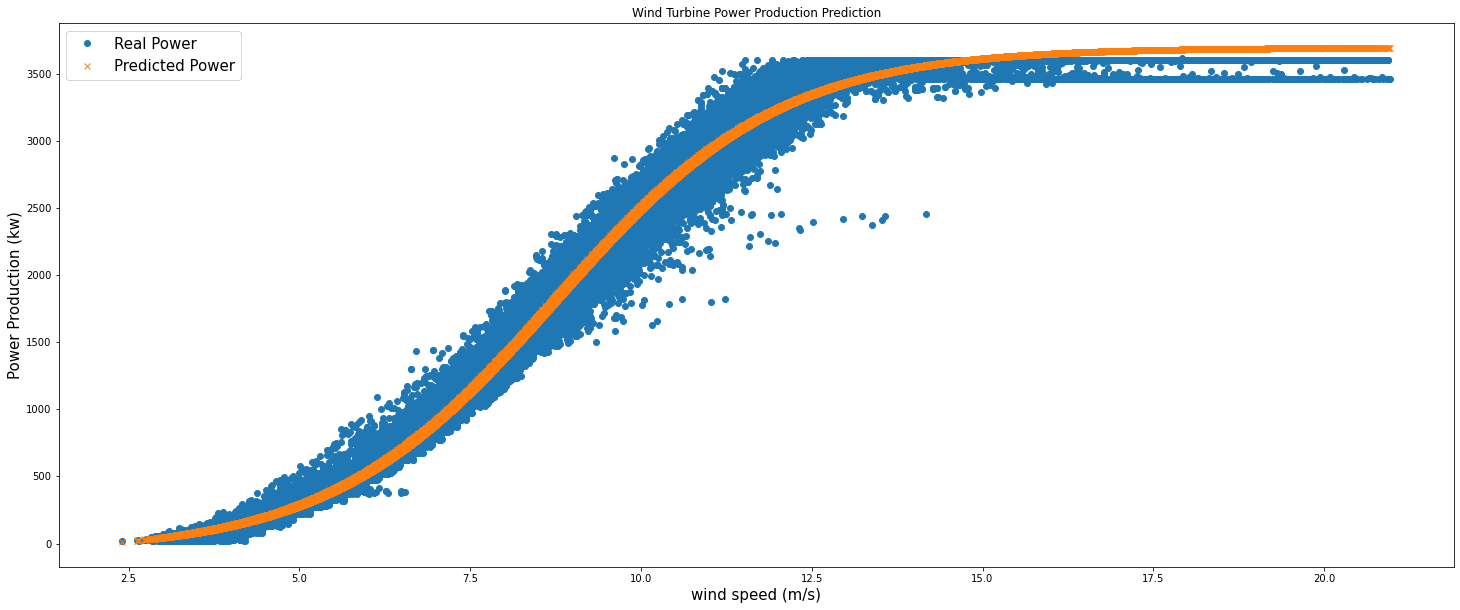

In [25]:
'''TO DO: Go here to remember the good virtue of the neural network. https://apmonitor.com/pds/index.php/Main/MultilayerPerceptronNeuralNetwork'''

y_predicted, y_actual = Models(MLPRegressor(hidden_layer_sizes = hls, activation = a, solver = s, max_iter = mi))
Graph_prediction(y_actual, y_predicted)

## Approach 2 ##
### Recurrent Neural Network (LSTM) ### 

42048 10512
42042
10506


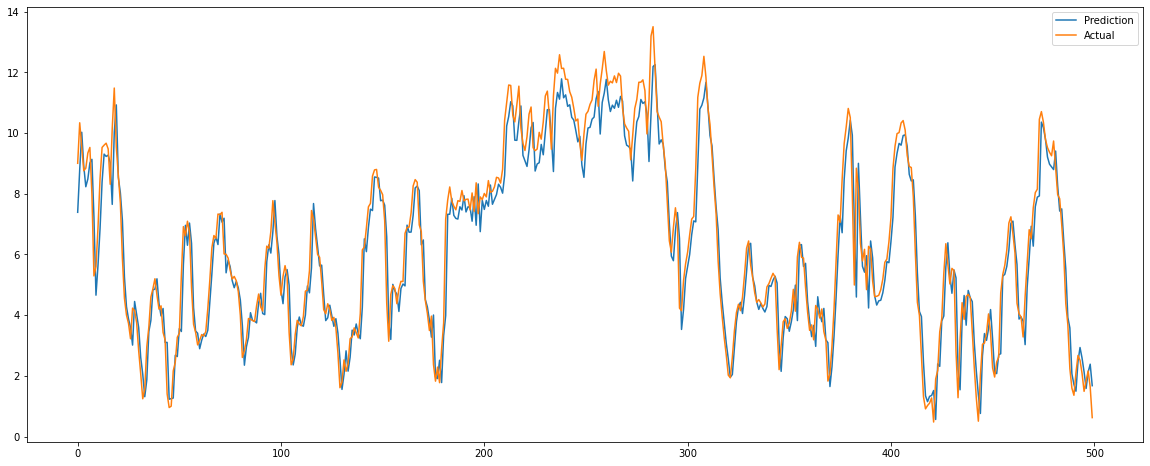

Mean squared error: 1.144
Root mean squared error: 1.069
R^2 : 0.875
Mean absolute error: 0.748


In [56]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import glob
from datetime import datetime
%matplotlib inline

''' Loading data '''
dataframe = pd.read_excel(r'C:\Users\ltlee\Downloads\wind.xlsx',index_col="DateTime")
dataframe.head()

''' Cleaning Data '''
dataframe['Power generated by system | (kW)'].replace(0, np.nan, inplace=True)
dataframe['Power generated by system | (kW)'].fillna(method='ffill', inplace=True)

''' Dividing data in test and train sets '''
dataset = dataframe.values
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

''' Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

''' Creating time frames with look backs '''
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

''' Re-shaping data for model requirement '''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

''' Fitting the data in LSTM Deep Learning model '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=15, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

yhat = model.predict(testX)

''' Plotting the first 500 entries to see prediction '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[:500], label='Prediction')
pyplot.plot(testY[:500], label='Actual')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

from sklearn.metrics import mean_squared_error, r2_score
print('R^2 : %.3f' % r2_score(testY, yhat))

from sklearn.metrics import mean_absolute_error
print("Mean absolute error: %.3f" % mean_absolute_error(testY, yhat))